### Planner

This notebook implements an LLM-based learning content generation module.

The pipeline creates personalized educational sequences by:

1. Planning a learning structure based on a topic and user profile;
2. Generating educational content for each step;
3. Replanning after content disclosure based on progress.

#### Setup and Imports

In [1]:
import os
import uuid
import operator
from typing import Annotated, Tuple, Union, TypedDict, List
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain.embeddings import init_embeddings
from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from langgraph.types import Command, interrupt
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph

#### Environment Configuration

In [2]:
load_dotenv(override = True)

True

In [3]:
THREAD = os.getenv("THREAD")
USER_ID = os.getenv("USER_ID")
OPENAI_CHAT_MODEL = os.getenv("OPENAI_CHAT_MODEL")
OPENAI_EMBED_MODEL = os.getenv("OPENAI_EMBED_MODEL")
OPENAI_API_PROXY = os.getenv("OPENAI_API_PROXY")
BASE_URL = os.getenv("BASE_URL")

In [4]:
llm = init_chat_model(api_key = OPENAI_API_PROXY, base_url = BASE_URL, model = OPENAI_CHAT_MODEL)

In [5]:
memory = MemorySaver()

In [ ]:
embeddings = init_embeddings(api_key = OPENAI_API_PROXY, base_url = BASE_URL, model = OPENAI_EMBED_MODEL)

In [7]:
store = InMemoryStore(index = {"embed": embeddings,"dims": 1536, "fields": ["memory", "type"]})

In [8]:
CONFIG = {'configurable': {'thread_id': THREAD, 'recursion_limit': 5, "user_id": USER_ID}}

#### Structured Output Models

In [9]:
class PlanExecute(TypedDict):
    """Structure for tracking and executing the learning plan."""
    input: str
    plan: list[str]
    past_steps: Annotated[list[Tuple], operator.add]
    learning_object: str
    conclusion: str

In [10]:
class Step(BaseModel):
    """Represents a single step in a learning plan."""
    title: str = Field(description="Concise, descriptive title (5-10 words)")
    description: str = Field(description="Clear explanation of what this step covers and how it connects to the learning journey")
    learning_objective: str = Field(description="Specific, measurable outcome the learner will achieve after completing this step")

In [11]:
class Plan(BaseModel):
    """Collection of ordered learning steps."""
    steps: List[Step] = Field(description="Ordered sequence of learning steps that build progressively")

In [12]:
class LearningObject(BaseModel):
    """Content delivered to the learner."""
    title: str = Field(description="Clear, engaging title that captures the essence of the content")
    content: str = Field(description="Educational material presented in a structured, accessible format (150-200 words)")

In [13]:
class Conclusion(BaseModel):
    """Final summary of the learning session."""
    conclusion: str = Field(description="Comprehensive summary that reinforces key points from the entire learning journey")

In [14]:
class Act(BaseModel):
    """Decision point for continuing or concluding the learning flow."""
    action: Union[Conclusion, Plan] = Field(
        description="Select either Plan (to continue with more steps) or Conclusion (to finalize the learning session)"
    )

#### Prompts

In [15]:
planner_ = """
    You are a learning experience designer creating educational sequences.
    Generate a structured learning plan with these characteristics:
        - Progressive steps that build upon each other (3-5 steps total)
        - Focus exclusively on the input topic without tangential concepts
        - Include introduction and focused main body sections
        - No conclusion or summary sections
        - Avoid overlapping content between steps
    """

In [16]:
learner_ = """
    You are an expert learning experience designer.
    Create a concise 'LearningObject' with these characteristics:
        - Clear, well-structured educational content (150-200 words)
        - Builds upon previous learning without unnecessary repetition
        - Short, descriptive title (maximum 10 words)
        - Focused content that achieves the specific learning objective
        - No preamble or summary text
    """

In [17]:
replaner_ = planner_ + """
    Evaluate progress and determine next action:
    
    Objective: {input}
    Original Plan: {plan}
    Completed Steps: {past_steps}

    Take one of these actions:
    - If all steps are completed: Provide a Conclusion containing the lesson's content
    - Otherwise: Update the plan with ONLY remaining steps, maintaining original detail level
    """

In [18]:
planner_prompt = ChatPromptTemplate.from_messages([("system", planner_),("placeholder", "{messages}")])
planner = planner_prompt | llm.with_structured_output(Plan)

In [19]:
learning_prompt = ChatPromptTemplate.from_messages([("system", learner_), ("placeholder", "{messages}")])
object = learning_prompt | llm.with_structured_output(LearningObject)

In [20]:
replanner_prompt = ChatPromptTemplate.from_template(replaner_)
replanner = replanner_prompt | llm.with_structured_output(Act)

#### User Profile Managemen

In [21]:
def profile(config=CONFIG, store=store):
    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "profile")
    profile_types = {"name": "Name", "interests": "Interests", "preferences": "Preferences", "goals": "Goals"}
    
    profile_data = {
        label: " ".join(m.value['memory'] for m in store.search(namespace, filter={'type': p_type}, limit=5))
        for p_type, label in profile_types.items()
    }
    
    return "\n".join(f"{label}: {content}" for label, content in profile_data.items())

In [22]:
def store_profile(content: str, profile_type: str,  config = CONFIG, store = store):
    VALID_PROFILE_TYPES = {"name", "interests", "preferences", "goals"}

    if profile_type not in VALID_PROFILE_TYPES:
        raise ValueError(f"Invalid profile_type: '{profile_type}'. Valid types are: {', '.join(VALID_PROFILE_TYPES)}.")
    
    user_id = config.get("configurable", {}).get("user_id")
    if not user_id:
        raise ValueError("User ID not found in configuration.")
           
    namespace = (user_id, "profile")
    memory_id = str(uuid.uuid4())
    store.put(namespace, key=memory_id, value={"memory": content, "type": profile_type}, index=False)
    return f"Stored information: '{content}' | ID: {memory_id}"

In [23]:
store_profile("Daniel", "name")
store_profile("Machine Learning and Artificial Intelligence", "interests")
store_profile("Detailed Real-Life Examples", "preferences")
store_profile("Becoming a Skilled Data Scientist and AI Expert", "goals")

print(profile())

Name: Daniel
Interests: Machine Learning and Artificial Intelligence
Preferences: Detailed Real-Life Examples
Goals: Becoming a Skilled Data Scientist and AI Expert


#### LangGraph Nodes

In [ ]:
def execute_step(state: PlanExecute):
    plan = state["plan"]
    current_step = plan[0]

    plan_str = "\n".join(
        f"{i+1}. {step.title}\nDescription: {step.description}\nLearning Objective: {step.learning_objective}\n"
        for i, step in enumerate(plan)
    )
    
    previous_steps_str = ". ".join(f'{i+1}. {desc}' for i, desc in enumerate(state["past_steps"])) if state["past_steps"] else ""
    
    if state["past_steps"]:
        prompt = f"""Given this overall learning plan: {plan_str}
            And, having already covered: {previous_steps_str}
            Your task is to execute step: {current_step}, building on previous information and anticipating future steps.
            Focus on clear explanations, avoid repeating previous points and ensure a smooth flow of learning."""
    else:
        prompt = f"""Given this learning plan: {plan_str}
            Your task is to execute step: {current_step}, focusing on clear explanations and anticipating future steps."""
    
    user_profile = profile()
    result = object.invoke({"messages": [("user", f"{prompt}\nPersonalize for user: {user_profile}")]})
    
    return {"past_steps": [current_step], "lo": result}

def plan_step(state: PlanExecute):
    user_profile = profile()
    plan = planner.invoke({"messages": [("user", f"{state['input']}\nPersonalize for user: {user_profile}")]})
    return {"plan": plan.steps}

def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    return (
        {"conclusion": output.action.conclusion} 
        if isinstance(output.action, Conclusion) 
        else {"plan": output.action.steps}
    )

def disclose(state: PlanExecute):
    return Command(goto="replan") if interrupt({"llm_output": state["lo"]}) else Command(goto=END)

def should_end(state: PlanExecute):
    return END if state.get("conclusion") else "learning_content"

In [37]:
learningflow = StateGraph(PlanExecute)

learningflow.add_node("planning", plan_step)
learningflow.add_node("learning_content", execute_step)
learningflow.add_node("replan", replan_step)
learningflow.add_node("disclosure", disclose)

learningflow.add_edge(START, "planning")
learningflow.add_edge("planning", "learning_content")
learningflow.add_edge("learning_content", "disclosure")
learningflow.add_edge("disclosure", "replan")

learningflow.add_conditional_edges("replan", should_end, ["learning_content", END])

planner = learningflow.compile(checkpointer = memory)

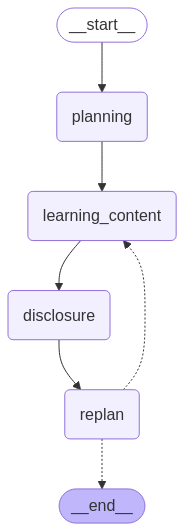

In [39]:
planner

#### Test Execution with HITL

In [ ]:
response = planner.invoke({"input": "Artificial Intellegence"}, config = CONFIG)

In [ ]:
for i, item in enumerate(response['plan'], start=1):
    print(f"\n{i}. {item.title.upper()}")
    print("-")
    print(f"{item.description}")
    print("-")
    print(f"{item.learning_objective}")


1. INTRODUCTION TO ARTIFICIAL INTELLIGENCE
-
Begin with an overview of what Artificial Intelligence (AI) is, its history, and its impact on various industries. Emphasize the transformative nature of AI and its role in innovation. Use diagrams and timelines to illustrate AI's development and its significant milestones. Highlight real-life examples, such as AI in healthcare for predictive analysis or AI in finance for fraud detection.
-
Understand the fundamental concepts and historical context of Artificial Intelligence.

2. CORE CONCEPTS OF MACHINE LEARNING
-
Dive into the essential theories underpinning Machine Learning, including supervised, unsupervised, and reinforcement learning. For each approach, provide real-life case studies demonstrating their application—like personalized recommendations in e-commerce (supervised learning) or customer segmentation (unsupervised learning). Use flowcharts to visualize how these methods work practically.
-
Familiarize with key Machine Learning

In [ ]:
print(response['learning_object'].content)

Artificial Intelligence (AI) revolutionizes how we solve problems and innovate across industries. It began in the mid-20th century, when pioneers like Alan Turing theorized computational thinking, leading to the first AI programs in the 1950s. Over time, AI's impact has grown, from IBM's Deep Blue defeating a chess grandmaster in 1997 to Google's AlphaGo winning against champion Go players in 2016.

AI enhances industries: in healthcare, predictive algorithms analyze patient data to foresee health issues; in finance, AI detects fraudulent transactions by analyzing patterns. These applications showcase AI's transformative power, optimizing efficiency and accuracy.

Visual aids, such as a timeline of AI milestones, illustrate its historical context. Diagrams can clarify AI concepts like neural networks, which mimic the human brain to learn and adapt. Real-life case studies, such as AI-driven diagnostic tools in hospitals, further demonstrate its practical implications.

Understanding AI'

In [ ]:
response = planner.invoke(Command(resume = "continue"), config = CONFIG)

In [ ]:
for i, item in enumerate(response['plan'], start=1):
    print(f"\n{i}. {item.title.upper()}")
    print("-")
    print(f"{item.description}")
    print("-")
    print(f"{item.learning_objective}")


1. CORE CONCEPTS OF MACHINE LEARNING
-
Dive into the essential theories underpinning Machine Learning, including supervised, unsupervised, and reinforcement learning. For each approach, provide real-life case studies demonstrating their application—like personalized recommendations in e-commerce (supervised learning) or customer segmentation (unsupervised learning). Use flowcharts to visualize how these methods work practically.
-
Familiarize with key Machine Learning concepts and their practical applications.

2. PROBLEM-SOLVING STRATEGIES IN AI
-
Explore how AI systems approach problem-solving, focusing on heuristic and algorithmic strategies. Describe problem-solving techniques such as search algorithms and optimization methods by using examples like route planning in logistic companies or game-playing AI such as AlphaGo. Visualize these strategies through step-by-step graphs and diagrams demonstrating their application in real-world scenarios.
-
Learn how AI algorithms solve compl

In [ ]:
print(response['learning_object'].content)

Machine Learning (ML) emerges as a pivotal tool in AI, offering diverse techniques for data-driven decision-making. Three primary categories to explore are supervised, unsupervised, and reinforcement learning. Supervised learning, widely used in e-commerce, allows models to predict future events based on historical data, like personalized product recommendations for users. Visualize this process as a flowchart where labeled data guides the prediction outcomes.

Unsupervised learning, another essential technique, excels in identifying patterns within data. It’s invaluable for customer segmentation, where data with no predefined labels are grouped based on inherent similarities. Imagine a visual clustering of customer profiles with common purchase behaviors evolving dynamically as new data arrives.

Reinforcement learning offers a strategic learning paradigm, where systems learn optimal actions through trial and error within dynamic environments. Consider AI’s implementation in gaming, s